## ARMYGRID 

This notebook analyses user behaviour in Armygrid web MMO game for current game server. 
The aim is to uncover insights about user engagement to identify points where users stop playing.

In [91]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import json

In [ ]:
import nltk
nltk.download('stopwords')

In [93]:
from textblob import TextBlob 
from wordcloud import WordCloud
from nltk.corpus import stopwords

In [94]:
from scipy.stats import pearsonr

In [95]:
def flatten_extended_json(obj):
    if isinstance(obj, dict):
        if "$numberInt" in obj:
            return int(obj["$numberInt"])
        elif "$numberDouble" in obj:
            return float(obj["$numberDouble"])
        elif "$date" in obj:
            return obj["$date"]
        else:
            return {k: flatten_extended_json(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [flatten_extended_json(i) for i in obj]
    else:
        return obj

In [96]:
def clean_id(val):
  return val['$oid']

Data sources used for this analysis include:

- user.json: Contains player data and game progression

- chats.json: Containes messages of users

In [97]:
with open("./db-json/user.json", "r") as f:
    user_records = [flatten_extended_json(json.loads(line)) for line in f]


In [98]:
with open("./db-json/chats.json", "r") as f:
    chat_records = [flatten_extended_json(json.loads(line)) for line in f]

In [99]:
user_df = pd.DataFrame(user_records)
user_df['_id'] = user_df['_id'].map(clean_id)

In [100]:
chat_df = pd.DataFrame(chat_records)
chat_df['_id'] = chat_df['_id'].map(clean_id)

We exclude game creator activity to ensure we only analyze real user behavior.

In [101]:
cleaned_users_df = user_df[
    (pd.to_datetime(user_df['createdAt']).dt.date >= pd.to_datetime('2025-03-10').date()) &
    (~user_df['username'].isin(['mansimas', 'salixaz'])) &
    (~user_df['after_wipe'])
]

Total players on current server

In [102]:
cleaned_users_df.shape[0]

4112

Each game server has a lifetime of 9 weeks after which it resets. Before going to main analysis, it is important to understand how many users continued to play from a previous one.

In [103]:
last_server_users_df = user_df[
  (pd.to_datetime(user_df['createdAt']).dt.date == pd.to_datetime('2025-03-10').date()) & 
  (~user_df['username'].isin(['mansimas', 'salixaz']))
]

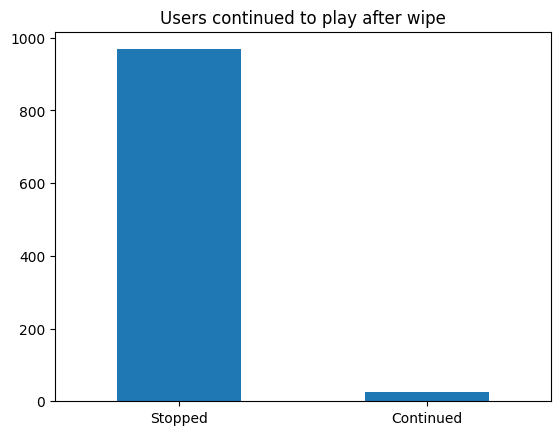

In [141]:

last_server_users_df.loc[:, 'after_wipe_label'] = last_server_users_df['after_wipe'].map({True: 'Stopped', False: 'Continued'})
last_server_users_df['after_wipe_label'].value_counts().plot(kind='bar', rot=0)

plt.xlabel('')
plt.title('Users continued to play after wipe')
plt.show()

From a bar chart it is clearly visible, that it is a small percentage. It indicates low engagement and also that further analysis will be based mostly on new users.

### General Information

Users can register using different gaming portals or from official Armygrid website. 

<Axes: xlabel='platform'>

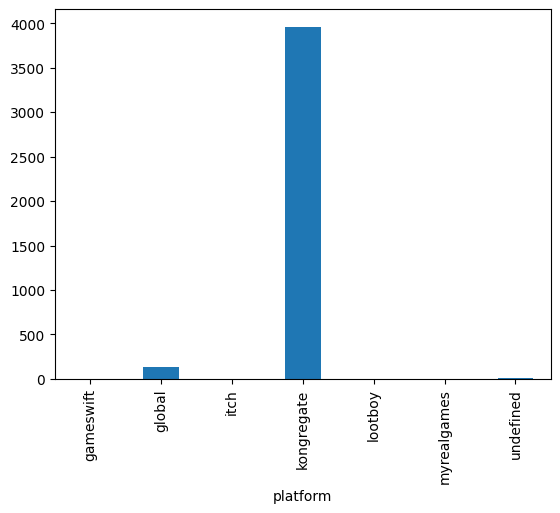

In [105]:
cleaned_users_df.loc[:, 'platform'] = cleaned_users_df['platform'].replace('', 'global')
platforms = cleaned_users_df.groupby(['platform']).size()
platforms.plot(kind='bar')

Chart above shows that almost all players are from Kongregrate, making it main source of users. On the second place is official Armygrid website. There are also users from other platforms like gameswift, but their amount is very low.

In [106]:
average_playtime = cleaned_users_df['playtime'].mean()
print(f'The average playtime is {round(average_playtime, 0)} minutes.')

The average playtime is 60.0 minutes.


Level distribution shows how users progress throughout the game. Since first level is a first glance where players will decide whether to conitnue, it is analyzed in proportion to higher levels.

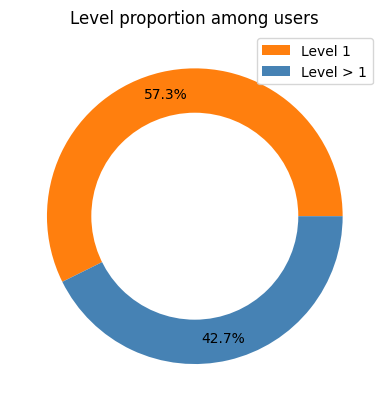

In [107]:
first_level = cleaned_users_df[cleaned_users_df['level'] == 1].size
other_levels = cleaned_users_df[cleaned_users_df['level'] != 1].size

level_proportion = [first_level, other_levels]
plt.pie(level_proportion, autopct='%1.1f%%', pctdistance=0.85, colors=['tab:orange', 'steelblue'])
plt.legend(['Level 1', 'Level > 1'])
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()

# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)
plt.title('Level proportion among users')
plt.show()

More than half of all users stops after level one which can indicate onboarding problems.

### 1st level players

To take a closer look at first level players, it is possible to check whether player made any action. First step in the game is to conquer a field. If user has 0 fields - no actions were made.

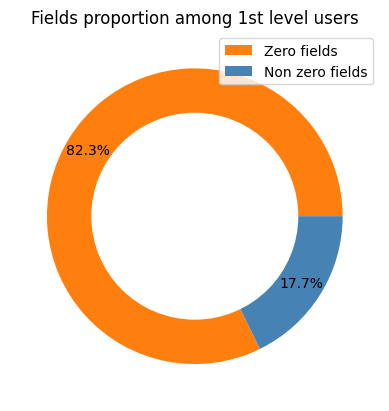

In [108]:
zero_fields_users = cleaned_users_df[(cleaned_users_df['level']==1) & (cleaned_users_df['rankings_fields'] == 0)].size
non_zero_fields_users = cleaned_users_df[(cleaned_users_df['level']==1) & (cleaned_users_df['rankings_fields'] != 0)].size

fields_proportion = [zero_fields_users, non_zero_fields_users]

plt.pie(fields_proportion, autopct='%1.1f%%', pctdistance=0.85, colors=['tab:orange', 'steelblue'])
plt.legend(['Zero fields', 'Non zero fields'])
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()

# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)
plt.title('Fields proportion among 1st level users')
plt.show()

In [109]:
print('Average playtime of 1st level users:', round(cleaned_users_df[cleaned_users_df['level'] == 1]['playtime'].mean(), 2), 'minutes')


Average playtime of 1st level users: 0.69 minutes


### Higher level users

Completing a specific campaign unlocks new game areas and features.

In [142]:
camp_tut_df = cleaned_users_df[cleaned_users_df['campaign_tutorial'] != 1]['campaign_tutorial'].value_counts().to_frame().reset_index()

all_camps = pd.DataFrame({'campaign_tutorial': np.arange(camp_tut_df['campaign_tutorial'].min(), camp_tut_df['campaign_tutorial'].max() + 1)})

# Merge with actual counts, filling missing with 0
full_camp_df = all_camps.merge(camp_tut_df, on='campaign_tutorial', how='left').fillna(0)
full_camp_df['count'] = full_camp_df['count'].astype(int)

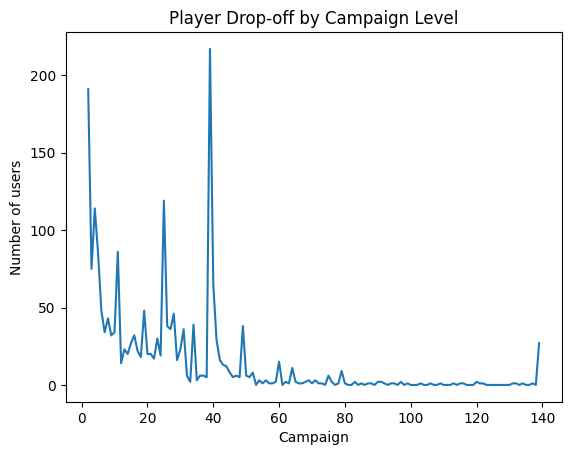

In [111]:
plt.plot(full_camp_df['campaign_tutorial'], full_camp_df['count'])
plt.xlabel('Campaign')
plt.ylabel('Number of users')
plt.title('Player Drop-off by Campaign Level')
plt.show()

There are several spikes after which number of players for the next campaign is remarkably lower. 
Only around 60th level it becomes stable.



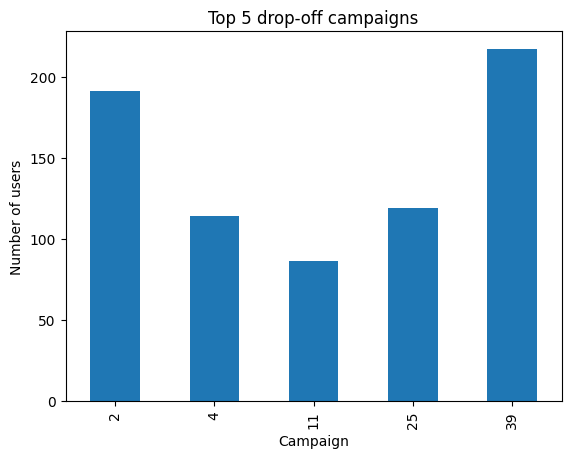

In [112]:
cleaned_users_df[cleaned_users_df['campaign_tutorial'] != 1]['campaign_tutorial'].value_counts().nlargest(5).sort_index().plot(kind='bar')
plt.title('Top 5 drop-off campaigns')
plt.xlabel('Campaign')
plt.ylabel('Number of users')
plt.show()

- Campaign 2 is reached when users conquer their first castle. 
- Campaign 4 shows tutorial on how to increase your stats.
- Campaign 11 does not unlock anything.

- Campaign 25 unlocks maze area and chat.
- Campaign 39 unlocks PvP zone and market.

## Maze

Maze is an area in the game which is designed like maze. 

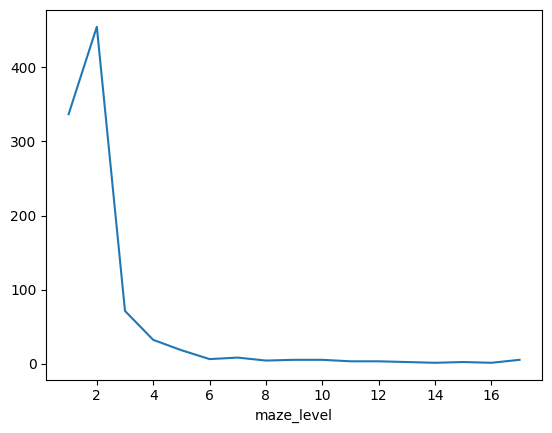

In [113]:
cleaned_users_df[cleaned_users_df['maze_level'] > 0]['maze_level'].value_counts().sort_index().plot()
plt.show()

The most significant drop is after Maze level 2.

## Cave

Cave is another area in game.

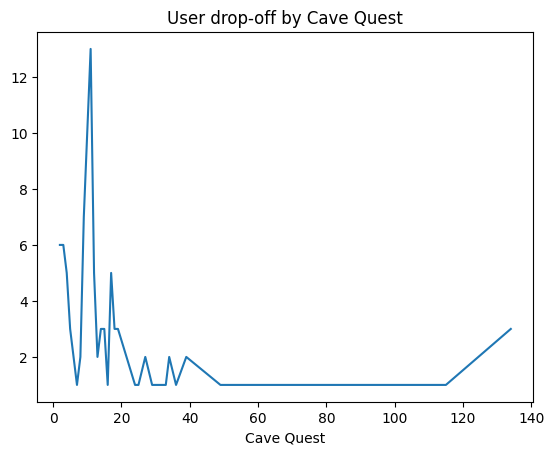

In [136]:
cleaned_users_df[cleaned_users_df['cave_quest'] > 1]['cave_quest'].value_counts().sort_index().plot()
plt.xlabel('Cave Quest')
plt.title('User drop-off by Cave Quest')
plt.show()

The most significan drop is after 11th quest.

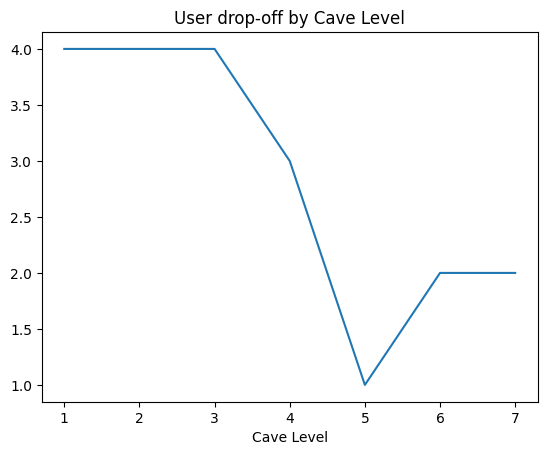

In [138]:
cleaned_users_df[cleaned_users_df['cave_level'] > 0]['cave_level'].value_counts().sort_index().plot()
plt.xlabel('Cave Level')
plt.title('User drop-off by Cave Level')
plt.show()

## Chat

Chat has several categories and here global messages from users will be analyzed.

In [116]:
global_messages = chat_df[chat_df['source'] == 'global']

In [117]:
cleaned_global_messages = global_messages[global_messages['username'] != 'mansimas']

In [130]:
print(f'{cleaned_global_messages.shape[0]} messages in chat')

690 messages in chat


In [118]:
users_have_chat = cleaned_users_df[cleaned_users_df['campaign_tutorial'] >= 9].shape[0]
users_written_in_chat = cleaned_global_messages['username'].unique().size

print(f'{round(users_written_in_chat / users_have_chat * 100, 1)}% of all users have written at least 1 message at chat')

3.2% of all users have written at least 1 message at chat


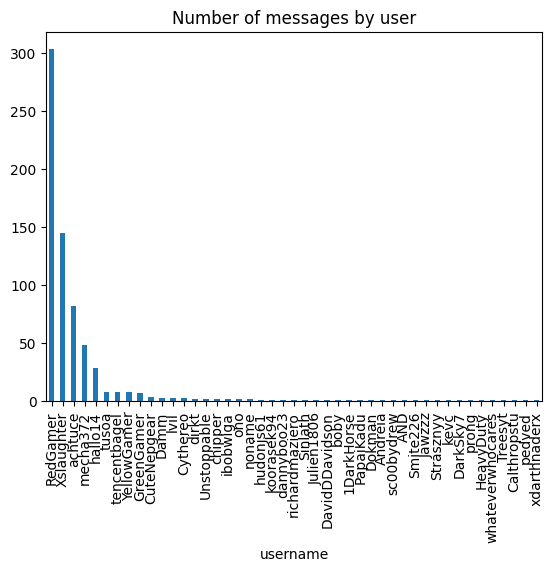

In [119]:
cleaned_global_messages['username'].value_counts().plot(kind='bar')
plt.title('Number of messages by user')
plt.show()

Only several users actively participate in chatting, while the majority write 1-10 messages.

In [133]:
amount_level = cleaned_global_messages['username'].value_counts().to_frame().merge(cleaned_users_df[['level', 'username']], on='username', how='left')
amount_level = amount_level.set_index('username')
corr, p_value = pearsonr(amount_level['level'], amount_level['count'])
print(f'Correlation between user level and amount of messages is {corr} and p value is {p_value}')

Correlation between user level and amount of messages is 0.7095362407478402 and p value is 4.852887110072493e-08


That indicates a strong positive relationship. The greater the level the greater the number of messages.

In [ ]:
cleaned_global_messages.loc[:, 'cleaned_text'] = (
    cleaned_global_messages['text']
    .astype(str)
    .str.lower()
    .str.replace(r'\n', ' ')     
    .str.replace(r'[^\w\s]', '', regex=True)  # remove punctuation
    .str.strip()
)

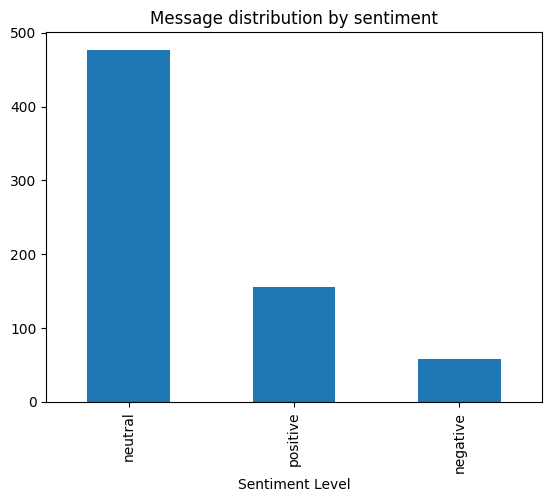

In [135]:
cleaned_global_messages.loc[:, 'sentiment'] = cleaned_global_messages['cleaned_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
cleaned_global_messages.loc[:, 'sentiment_label'] = cleaned_global_messages['sentiment'].apply(
    lambda x: 'positive' if x > 0.2 else ('negative' if x < -0.2 else 'neutral')
)

cleaned_global_messages['sentiment_label'].value_counts().plot(kind='bar')
plt.xlabel('Sentiment Level')
plt.title('Message distribution by sentiment')
plt.show()

The total number of neutral and positive sentiment messages highly greater than negative ones. That indicates in general positive impressions from game.

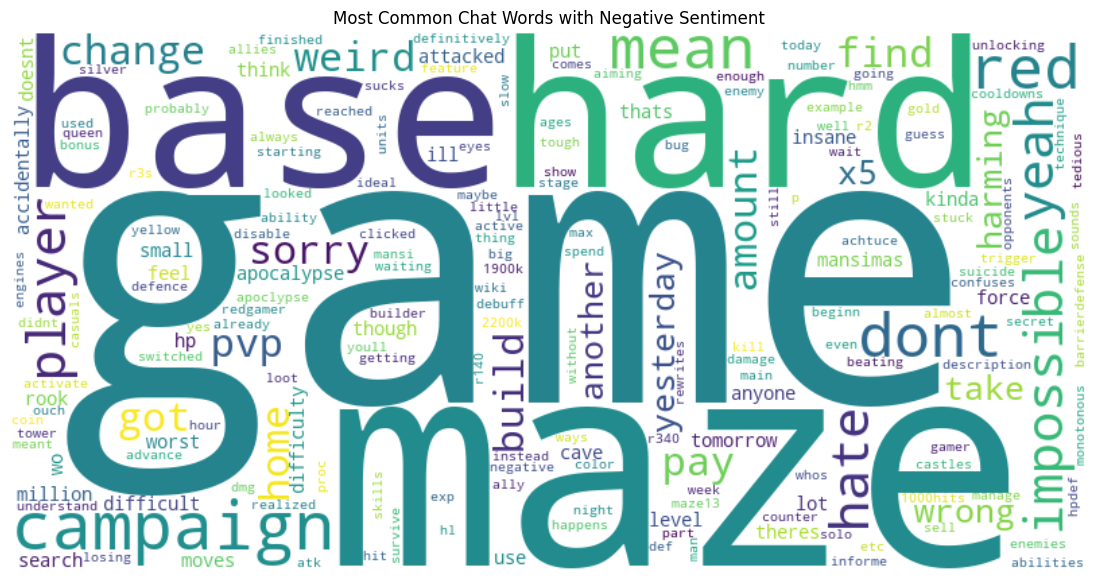

In [ ]:
stop_words = set(stopwords.words('english'))

# Combine all words
all_words = ' '.join(cleaned_global_messages[cleaned_global_messages['sentiment_label'] == 'negative']['cleaned_text'])

filtered_words = ' '.join([word for word in all_words.split() if word not in stop_words])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(filtered_words)

# Display
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Chat Words with Negative Sentiment')
plt.show()

There are words like 'hard', 'impossible' which can indicates that some part of the game, like Maze, is difficult for player to either understand or complete.

Export data frames to CSV files

In [ ]:
cleaned_users_df.to_csv('./output/cleaned_users.csv')

In [ ]:
cleaned_global_messages.to_csv('./output/cleaned_global_messages.csv')

That is it!